# Teste - Cientista de Dados

**Autor** - Leonardo Fernandes Moutinho Rocha

Uma empresa de mineração de diamantes pretende estimar o peso total em quilates
extraído com base nas condições de campo. Para isso, é necessário encontrar uma
distribuição estatística que se ajuste bem aos dados e, com base nela, serão
gerados valores aleatórios para estimar probabilidades de peso total extraído
com base no número diário de diamantes.
  1. Utilizando o data-set fornecido, de dados de diamantes, encontre uma curva
  que bem se adequa à variável carat (peso em quilates). Para isso, proponha
  pelo menos três distribuições que representam de forma adequada os dados e
  utilize um critério de seleção de modelos para determinar a melhor
  distribuição.
  2. Com base na distribuição escolhida, gere um histograma que representa a
  distribuição do peso total extraído pela empresa caso sejam extraídas 100
  unidades de diamantes por dia. Qual a distribuição dessa variável peso total?
  3. Explique o passo a passo e discorra sobre os resultados.

## Imports

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from pomegranate import LogNormalDistribution, GeneralMixtureModel
from scipy import stats

In [107]:
seed = 27

## Carregando os dados

Para carregar os dados selecionamos apenas a coluna de interesse **carat**.
Em seguida a compactamos para um `pd.Series` ao invés de trabalhar com
um `pd.DataFrame` de apenas uma coluna. Como resultado obtemos uma série de
dados numérica (`float`) sem registros faltantes.

In [108]:
# os dados da série de carat com 
filepath = "Teste Ciência de Dados diamonds.csv"
carat = pd.read_csv(filepath, usecols=["carat"]).squeeze("columns")
carat.head()

0    0.23
1    0.21
2    0.23
3    0.29
4    0.31
Name: carat, dtype: float64

In [109]:
carat.info()

<class 'pandas.core.series.Series'>
RangeIndex: 53940 entries, 0 to 53939
Series name: carat
Non-Null Count  Dtype  
--------------  -----  
53940 non-null  float64
dtypes: float64(1)
memory usage: 421.5 KB


In [110]:
x_train, x_test = train_test_split(carat, test_size=.2, random_state=seed)

# Análise preliminar da distribuição dos dados

Em uma análise prelininar das estatísticas descritvas da distribuição de
`carat`, conseguimos identificar indícios de que a distribuição seja
assimétrica. Mais especificamente com uma **assimetria para a direita**,
uma vez que a média (0.80) é maior que a mediana (0.70). O intervalo máximo
dessa distribuição também não é muito grande. O menor valor é 0.2 enquanto o 
maior 5.01. Reforçando a evidência de assimetria à direita, apesar do máximo
ser 5.01, como dito anteriormente, 75% dos valores estão a baixo de 1.04.

In [111]:
x_train.describe().round(2)

count    43152.00
mean         0.80
std          0.47
min          0.20
25%          0.40
50%          0.70
75%          1.04
max          4.50
Name: carat, dtype: float64

In [112]:
def plot_distr(x: pd.Series) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    sns.boxplot(x=x, ax=ax1)
    x.hist(bins=100, density=True, ax=ax2)
    x.value_counts(normalize=True).sort_index().cumsum().plot(ax=ax3)
    plt.show()

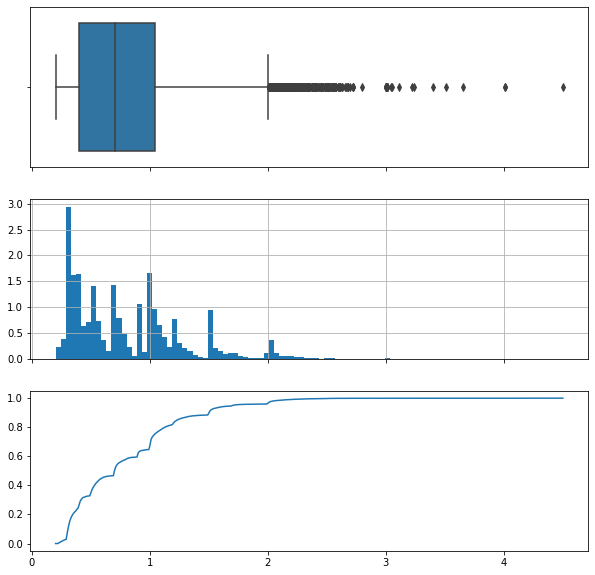

In [113]:
plot_distr(x_train)

In [114]:
log_x_train = x_train.apply(np.log)
log_x_train.describe()

count    43152.000000
mean        -0.394967
std          0.584857
min         -1.609438
25%         -0.916291
50%         -0.356675
75%          0.039221
max          1.504077
Name: carat, dtype: float64

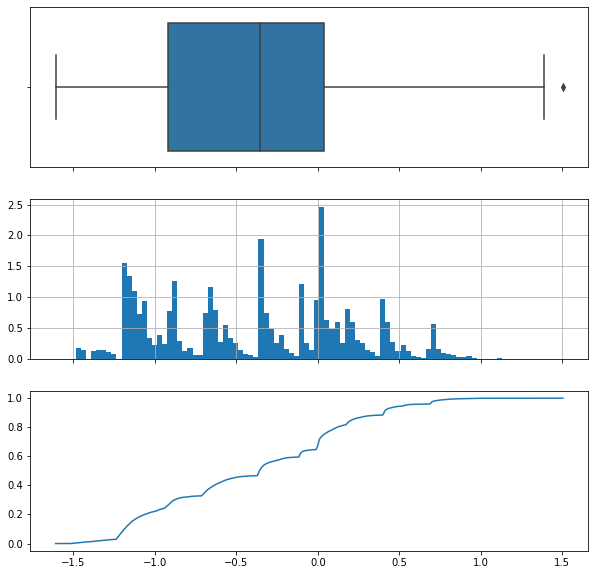

In [115]:
plot_distr(log_x_train)

Em geral a distribuição de carats pode ser representado por um modelo lognormal.
Porém como é possível observar pelas figuras. Esse não parece ser o caso. Isso
fica claro quando observamos que o histograma é relativo a uma distribuição
multimodal. Isso é um indicativo de que a distribuição pode ser a de um modelo
de misturas. Por hipótese vamos supor que é a de um modelo de mistura composto
por vários modelos lognormais.

Essa hipótese está respaldada pela literatura especializada. Segundo XXXX (YYYY),
apesar de em geral a distribuição de carats de diamantes serem lognormais, quando
quando a amostra contém dados de multiplas minas, é comum que a distribuição seja
uma mistura de lognormais. Isso é equivalente dizer, que a amostra é oriunda de
múltiplas populações cuja distribuição é lognormal.

Definida nossa hipótese mais geral, que a a distribuição de carats de nossa amostra
é um modelo de misturas de lognormais, cabe agora definir de quantas misturas
estamos tratando. Como a distribuição lognormal é unimodal, uma hipótese preliminar
seria assumir como a quantidade de lognormais a quantidade de modas que conseguimos
identificar em nosso histograma.

Esse valor vai ser um chute inicial, para balisar nosso espaço de busca. Dessa forma,
não vamos fazer nenhum teste preliminar a respeito da multimodalidade da distribuição.
Visualmente conseguimos identificar algum valor entre 4 e 7. Dessa forma, a gama de
possibilidades que iremos avaliar precisa compreender esse intervalo. Pelo histograma,
parece ser bem pouco provável que tenhamos uma quantidade muito superior a 10.

Para avaliar vamos utilizar a divergência de Kulllback-leibler. Esta é uma medida
amplamente utilizada na inferência Bayesiana que mede o quanto perdemos de informação
quando estamos utilizando um distribuição Q para representar uma outra distribuição P.
Com isso, quanto menor for esse indicador melhor será nossa representação dos dados.

In [116]:
def get_kl_divergence(x, model):
    
    x_pdf = x.value_counts(normalize=True).sort_index()
    
    q = model.probability(x_pdf.index) / 100
    p = x_pdf.values
    
    return np.sum(np.where(q !=0, p * np.log(p/q), 0))

In [117]:
def cross_val(n_components_range: list[int],
              x: pd.Series=x_train,
              cv: int=10,
              ks_sample_size: int=500) -> pd.DataFrame:
    
    result = dict(n_component=list(),
                  train_kl=list(),
                  test_kl=list(),
                  ks_stats=list(),
                  ks_pvalue=list())
    
    x.reset_index(drop=True, inplace=True)
    kf = KFold(n_splits=cv)
    kf.get_n_splits(x)
    
    for n_component in n_components_range:        
        for train_index, test_index in kf.split(x):
            train = x[train_index]
            test = x[test_index]
            
            train_reshaped = train.values.reshape(train.shape[0], 1)
            model = GeneralMixtureModel.from_samples(LogNormalDistribution,
                                                     n_component,
                                                     train_reshaped)
            train_kl = get_kl_divergence(train, model)
            test_kl = get_kl_divergence(test, model)
            ks_stats, ks_pvalue = stats.ks_2samp(test.sample(ks_sample_size).values,
                                                 model.sample(ks_sample_size))
            
            result["n_component"].append(n_component)
            result["train_kl"].append(train_kl)
            result["test_kl"].append(test_kl)
            result["ks_stats"].append(ks_stats)
            result["ks_pvalue"].append(ks_pvalue)
    
    return pd.DataFrame(result)

In [118]:
np.random.seed(seed)
result = cross_val(n_components_range=range(2, 15, 1), cv=10)
result["significant"] = result["ks_pvalue"] < 0.05
result.dropna().groupby("n_component").agg(["mean", "std"])

train_kl             test_kl            ks_stats            \
                 mean       std      mean       std      mean       std   
n_component                                                               
2            0.471978  0.001441  0.499120  0.013488  0.088800  0.023366   
3            0.445854  0.006556  0.473529  0.013998  0.088600  0.015407   
4            0.362362  0.031499  0.391558  0.038745  0.085800  0.021133   
5            0.368599  0.019587  0.393384  0.020887  0.078200  0.017396   
6            0.320078  0.020909  0.347313  0.024116  0.079000  0.019351   
7            0.288598  0.025679  0.315245  0.026525  0.071200  0.022135   
8            0.279354  0.006528  0.310450  0.011993  0.069000  0.016553   
9            0.206097  0.097011  0.223785  0.124373  0.068200  0.014405   
10           0.217093  0.038384  0.246169  0.041005  0.067333  0.014318   
11           0.184923  0.036814  0.211539  0.033945  0.065000  0.010801   
12           0.181411  0.037403  0.208215  0.045689  0.059778  0.021828   
13           0.139816  0.025152  0.165073  0.028127  0.065750  0.017450   
14           0.114720  0.131075  0.150943  0.113758  0.072250  0.025127   

            ks_pvalue           significant            
                 mean       std        mean       std  
n_component                                            
2            0.097750  0.098863    0.400000  0.516398  
3            0.064640  0.063824    0.500000  0.527046  
4            0.120141  0.159191    0.500000  0.527046  
5            0.138383  0.090833    0.200000  0.421637  
6            0.158217  0.167955    0.300000  0.483046  
7            0.258618  0.208531    0.100000  0.316228  
8            0.261645  0.218873    0.200000  0.421637  
9            0.255118  0.200698    0.200000  0.421637  
10           0.263050  0.162550    0.222222  0.440959  
11           0.278807  0.186404    0.000000  0.000000  
12           0.452464  0.308168    0.111111  0.333333  
13           0.315905  0.270579    0.125000  0.353553  
14           0.276896  0.286134    0.375000  0.517549

In [119]:
def gen_mixture_lognormal_model(X_series, n_components):
    X_vals = X_series.values.reshape(X_series.shape[0], 1)
    return GeneralMixtureModel.from_samples(LogNormalDistribution,
                                            n_components,
                                            X_vals)

In [120]:
def plot_density(X_series, x, model, ax):
    ax.hist(X_series, density=True, bins=100)
    ax.plot(x, model.probability(x), label="density")

In [121]:
def plot_cdf(X_series, x, model, ax):
    prob = model.probability(x) / 100
    cumprob = prob.cumsum()
    
    X_series.value_counts(normalize=True).sort_index().cumsum().plot(ax=ax)
    ax.plot(x, cumprob)

In [122]:
good_candidates = range(7, 13)
model_list = [gen_mixture_lognormal_model(x_train, candidate)
              for candidate in good_candidates]

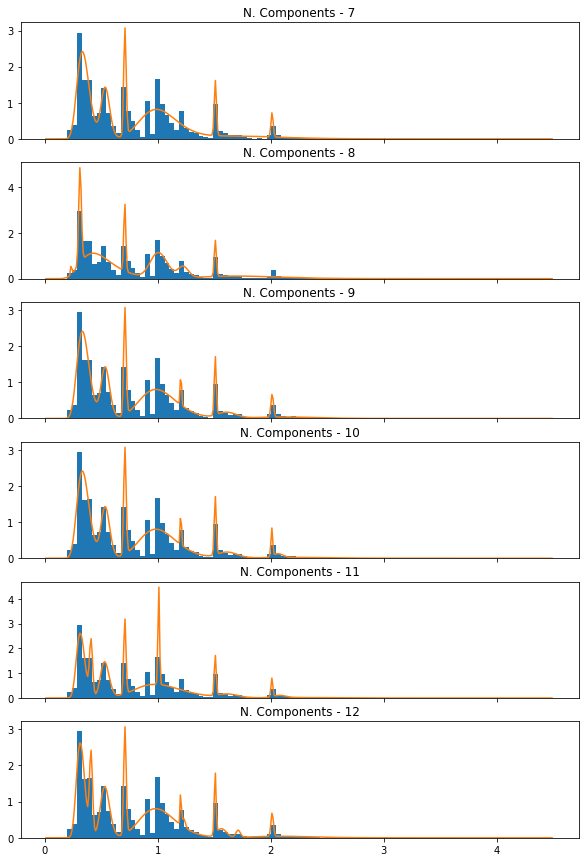

In [123]:
x = np.arange(0.01, x_train.max(), 0.01)
fig, axs = plt.subplots(len(model_list), 1, figsize=(10, 15), sharex=True)
for ax, model, n_component in zip(axs, model_list, good_candidates):
    plot_density(x_train, x, model, ax)
    ax.set_title(f"N. Components - {n_component}")
plt.show()

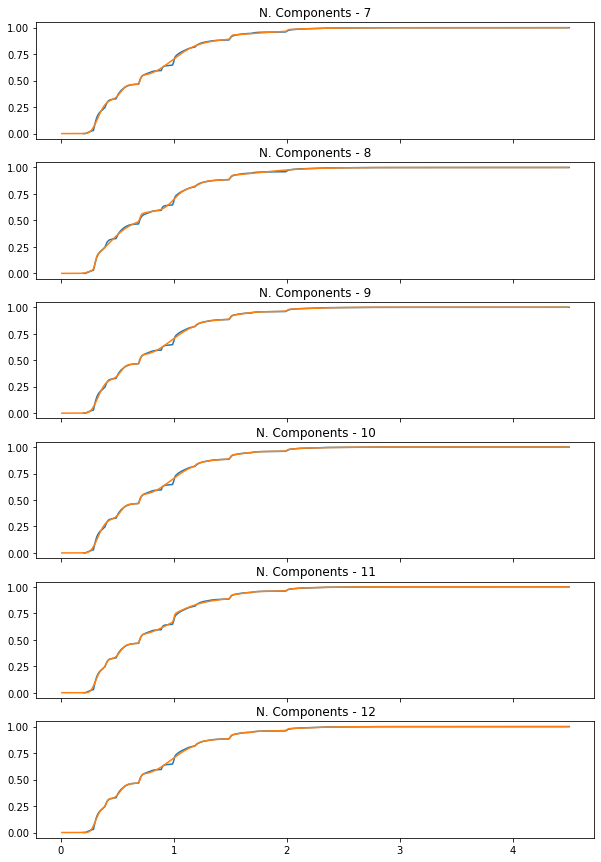

In [124]:
x = np.arange(0.01, x_train.max(), 0.01)
fig, axs = plt.subplots(len(model_list), 1, figsize=(10, 15), sharex=True)
for ax, model, n_component in zip(axs, model_list, good_candidates):
    plot_cdf(x_train, x, model, ax)
    ax.set_title(f"N. Components - {n_component}")
plt.show()

Analisando os gráficos acima é possível observar que, como esperado, todos são muito parecidos. Em geral, quanto maior a quantidade de componentes em um modelo de misturas lognormal, maior vai ser a flexbilidade do modelo em reproduzir a distribuição. Não foi possível através das estatísticas apresentadas identificar o modelo que é abolutamente superior aos outros.

Comparando os gráficos a quantidade de componentes escolhida foi a de 11. Aparentemente 11 componentes é a especificação que gerou um modelo com maior capacidade de representar os diamentes com maior peso.

Em seguida, vamos gerar um modelo com 11 componentes lognormais, gerar um histograma que represente a distribuição do peso total extraído, dado que 100 diamentes são extraídos por dia.

In [125]:
model = gen_mixture_lognormal_model(x_train, 11)

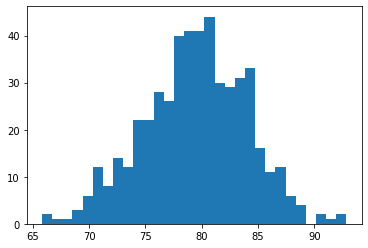

In [126]:
sample_size = [np.sum(model.sample(100)) for _ in range(500)]
plt.hist(sample_size, bins=30)
plt.show()

Visualizando o histograma dessa distribuição é bem provável que ela seja uma distribuição normal. Vamos testar essa hipótese utilizando o KS teste.

In [127]:
def ks_test(x: pd.Series, distr_name: str, stats_obj: stats.rv_continuous):
    
    params = stats_obj.fit(x)
    print(params)
    return stats.kstest(x, distr_name, params)

In [128]:
ks_test(sample_size, "norm", stats.norm)

(79.44297260467488, 4.564632131411821)


KstestResult(statistic=0.036851887687413765, pvalue=0.49403831197240644)

Como esperado a amostra gerada segue uma distribuição normal. Sendo que sua média é de 79.44 e seu desvio padrão de 4.56